In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.3
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 11s - loss: 0.0579

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 590ms/step - loss: 0.0470
Average validation loss: 0.5815374851226807
4/4 [==============================] - 6s 602ms/step - loss: 0.0470 - val_loss: 0.5815
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 576ms/step - loss: 0.0329 - val_loss: 0.5815
Average validation loss: 0.4773641526699066
4/4 [==============================] - 8s 590ms/step - loss: 0.0329 - val_loss: 0.5295
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 10s 574ms/step - loss: 0.0246 - val_loss: 0.5295
Average validation loss: 0.27345824241638184
4/4 [==============================] - 10s 586ms/step - loss: 0.0246 - val_los

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 5s 674ms/step - loss: 4.0034e-05
Average validation loss: 0.0002772371517494321
8/8 [==============================] - 5s 686ms/step - loss: 4.0034e-05 - val_loss: 2.7724e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 698ms/step - loss: 4.0788e-05 - val_loss: 2.7724e-04
Average validation loss: 0.0017091119079850614
8/8 [==============================] - 11s 710ms/step - loss: 4.0788e-05 - val_loss: 9.9317e-04
Epoch 3/10
8/8 [==============================] - 17s 683ms/step - loss: 4.1159e-05 - val_loss: 9.9317e-04
Average validation loss: 1.648813395149773e-05
8/8 [==============================] - 17s 697ms/step - loss: 4.1159e-05 - val_loss: 6.6761e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segform

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 694ms/step - loss: 8.6882e-05
Average validation loss: 0.07385428269064025
12/12 [==============================] - 8s 704ms/step - loss: 8.6882e-05 - val_loss: 0.0739
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 688ms/step - loss: 8.4407e-05 - val_loss: 0.0739
Average validation loss: 0.02732298399011294
12/12 [==============================] - 17s 698ms/step - loss: 8.4407e-05 - val_loss: 0.0506
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 25s 710ms/step - loss: 7.8281e-05 - val_loss: 0.0506
Average validation loss: 0.02725571290163013
12/12 [==============================] - 2

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 697ms/step - loss: 4.4346e-05
Average validation loss: 0.061597220577823464
16/16 [==============================] - 11s 707ms/step - loss: 4.4346e-05 - val_loss: 0.0616
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 713ms/step - loss: 4.6244e-05 - val_loss: 0.0616
Average validation loss: 0.01839005248621106
16/16 [==============================] - 23s 724ms/step - loss: 4.6244e-05 - val_loss: 0.0400
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 34s 712ms/step - loss: 4.9108e-05 - val_loss: 0.0400
Average validation loss: 0.025629081530496478
16/16 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 679ms/step - loss: 3.2882e-05
Average validation loss: 0.025273829270736313
20/20 [==============================] - 14s 691ms/step - loss: 3.2882e-05 - val_loss: 0.0253
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 28s 697ms/step - loss: 2.8501e-05 - val_loss: 0.0253
Average validation loss: 0.023762635118328036
20/20 [==============================] - 28s 707ms/step - loss: 2.8501e-05 - val_loss: 0.0245
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 42s 687ms/step - loss: 2.8008e-05 - val_loss: 0.0245
Average validation loss: 0.05549628362059593
20/20 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 703ms/step - loss: 4.3575e-05
Average validation loss: 0.026246860933800537
24/24 [==============================] - 17s 713ms/step - loss: 4.3575e-05 - val_loss: 0.0262
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 34s 700ms/step - loss: 4.1166e-05 - val_loss: 0.0262
Average validation loss: 0.07783127203583717
24/24 [==============================] - 34s 710ms/step - loss: 4.1166e-05 - val_loss: 0.0520
Epoch 3/10
24/24 [==============================] - 51s 697ms/step - loss: 3.5692e-05 - val_loss: 0.0520
Average validation loss: 0.019487851454565924
24/24 [==============================] - 51s 707ms/step - loss: 3.5692e-05 - val_loss: 0.0412
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/we

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 30s 757ms/step - loss: 7.7214e-05
Average validation loss: 0.08218537792563438
40/40 [==============================] - 31s 768ms/step - loss: 7.7214e-05 - val_loss: 0.0822
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 61s 763ms/step - loss: 6.8425e-05 - val_loss: 0.0822
Average validation loss: 0.031884259171783925
40/40 [==============================] - 62s 774ms/step - loss: 6.8425e-05 - val_loss: 0.0570
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 92s 762ms/step - loss: 6.2998e-05 - val_loss: 0.0570
Average validation loss: 0.06271568443626166
40/40 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 37s 765ms/step - loss: 4.3637e-05
Average validation loss: 0.057371414344136916
48/48 [==============================] - 37s 776ms/step - loss: 4.3637e-05 - val_loss: 0.0574
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 74s 760ms/step - loss: 3.3855e-05 - val_loss: 0.0574
Average validation loss: 0.03509777889121324
48/48 [==============================] - 74s 770ms/step - loss: 3.3855e-05 - val_loss: 0.0462
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 111s 764ms/step - loss: 2.9598e-05 - val_loss: 0.0462
Average validation loss: 0.13476102788918828
48/48 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 39s 704ms/step - loss: 5.8441e-05
Average validation loss: 0.034203398327268326
56/56 [==============================] - 40s 714ms/step - loss: 5.8441e-05 - val_loss: 0.0342
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 79s 695ms/step - loss: 4.1011e-05 - val_loss: 0.0342
Average validation loss: 0.022517141570071026
56/56 [==============================] - 80s 705ms/step - loss: 4.1011e-05 - val_loss: 0.0284
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 119s 712ms/step - loss: 3.4725e-05 - val_loss: 0.0284
Average validation loss: 0.031026211567223072
56/56 [=============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 49s 769ms/step - loss: 3.4099e-05
Average validation loss: 0.02723836112159006
64/64 [==============================] - 50s 780ms/step - loss: 3.4099e-05 - val_loss: 0.0272
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 99s 761ms/step - loss: 2.3933e-05 - val_loss: 0.0272
Average validation loss: 0.025838617057331703
64/64 [==============================] - 99s 772ms/step - loss: 2.3933e-05 - val_loss: 0.0265
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 148s 763ms/step - loss: 1.8587e-05 - val_loss: 0.0265
Average validation loss: 0.0107409928823472
64/64 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 56s 772ms/step - loss: 3.4554e-05
Average validation loss: 0.04250778847684463
72/72 [==============================] - 56s 783ms/step - loss: 3.4554e-05 - val_loss: 0.0425
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 112s 766ms/step - loss: 2.4976e-05 - val_loss: 0.0425
Average validation loss: 0.025831693679922156
72/72 [==============================] - 112s 777ms/step - loss: 2.4976e-05 - val_loss: 0.0342
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 167s 765ms/step - loss: 2.0456e-05 - val_loss: 0.0342
Average validation loss: 0.015594389212007323
72/72 [============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 61s 767ms/step - loss: 2.7862e-05
Average validation loss: 0.014207896776497364
80/80 [==============================] - 62s 778ms/step - loss: 2.7862e-05 - val_loss: 0.0142
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 124s 772ms/step - loss: 1.8193e-05 - val_loss: 0.0142
Average validation loss: 0.014430751092731953
80/80 [==============================] - 125s 784ms/step - loss: 1.8193e-05 - val_loss: 0.0143
Epoch 3/10
80/80 [==============================] - 186s 769ms/step - loss: 1.4354e-05 - val_loss: 0.0143
Average validation loss: 0.00950767712201923
80/80 [==============================] - 187s 779ms/step - loss: 1.4354e-05 - val_loss: 0.0127
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_06

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 68s 705ms/step - loss: 5.1246e-05
Average validation loss: 0.028074315322252612
96/96 [==============================] - 69s 716ms/step - loss: 5.1246e-05 - val_loss: 0.0281
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 136s 706ms/step - loss: 3.5985e-05 - val_loss: 0.0281
Average validation loss: 0.022026618612774957
96/96 [==============================] - 137s 716ms/step - loss: 3.5985e-05 - val_loss: 0.0251
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 205s 706ms/step - loss: 2.7490e-05 - val_loss: 0.0251
Average validation loss: 0.019185043032242294
96/96 [=========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 84s 703ms/step - loss: 2.9004e-05
Average validation loss: 0.019943414690593877
120/120 [==============================] - 86s 713ms/step - loss: 2.9004e-05 - val_loss: 0.0199
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 169s 697ms/step - loss: 1.9851e-05 - val_loss: 0.0199
Average validation loss: 0.009181666420772672
120/120 [==============================] - 170s 707ms/step - loss: 1.9851e-05 - val_loss: 0.0146
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 255s 705ms/step - loss: 1.5676e-05 - val_loss: 0.0146
Average validation loss: 0.010731884425816436
120/120 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 102s 705ms/step - loss: 2.3916e-05
Average validation loss: 0.011789624527510669
144/144 [==============================] - 103s 715ms/step - loss: 2.3916e-05 - val_loss: 0.0118
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 204s 703ms/step - loss: 1.7612e-05 - val_loss: 0.0118
Average validation loss: 0.010521496581431065
144/144 [==============================] - 206s 714ms/step - loss: 1.7612e-05 - val_loss: 0.0112
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 307s 702ms/step - loss: 1.3478e-05 - val_loss: 0.0112
Average validation loss: 0.01020655011881091
144/144 [============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 113s 706ms/step - loss: 1.0246e-05
Average validation loss: 0.012483929093741608
160/160 [==============================] - 115s 716ms/step - loss: 1.0246e-05 - val_loss: 0.0125
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 227s 703ms/step - loss: 8.0737e-06 - val_loss: 0.0125
Average validation loss: 0.03265044091220091
160/160 [==============================] - 229s 713ms/step - loss: 8.0737e-06 - val_loss: 0.0226
Epoch 3/10
160/160 [==============================] - 342s 709ms/step - loss: 6.7331e-06 - val_loss: 0.0226
Average validation loss: 0.009493241918244166
160/160 [==============================] - 344s 718ms/step - loss: 6.7331e-06 - val_loss: 0.0182
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_K

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 141s 702ms/step - loss: 5.0256e-05
Average validation loss: 0.010709699662402272
200/200 [==============================] - 143s 712ms/step - loss: 5.0256e-05 - val_loss: 0.0107
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 283s 704ms/step - loss: 3.4999e-05 - val_loss: 0.0107
Average validation loss: 0.010999484995845705
200/200 [==============================] - 285s 714ms/step - loss: 3.4999e-05 - val_loss: 0.0109
Epoch 3/10
200/200 [==============================] - 427s 706ms/step - loss: 2.6735e-05 - val_loss: 0.0109
Average validation loss: 0.008878043070435524
200/200 [==============================] - 429s 716ms/step - loss: 2.6735e-05 - val_loss: 0.0102
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:47 - loss: 2.2627e-06

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 169s 705ms/step - loss: 2.2176e-05
Average validation loss: 0.013111404213123023
240/240 [==============================] - 172s 715ms/step - loss: 2.2176e-05 - val_loss: 0.0131
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 340s 702ms/step - loss: 1.5275e-05 - val_loss: 0.0131
Average validation loss: 0.009916351123441322
240/240 [==============================] - 342s 712ms/step - loss: 1.5275e-05 - val_loss: 0.0115
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_30\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 513s 712ms/step - loss: 1.2645e-05 - val_loss: 0.0115
Average validation loss: 0.010940412389027187
240/240 [===========

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.10046557245048461, 0.05089100427178437, 0.06011603583070607, 0.028723881202395204, 0.01802447264023067, 0.022223218854547307, 0.029552988167080005, 0.021329422654675148, 0.0199136992350967, 0.01699645062319064, 0.016458306359294916, 0.01614846034877894, 0.014058779542271319, 0.012018488516213741, 0.01195628989560368, 0.012951101743712003, 0.012393413232547572, 0.011826232328444031]
std_val_losses =  [0.12773496485961752, 0.05196428891381672, 0.05147863272701216, 0.011865416374329394, 0.0074740079882318925, 0.03214323601686999, 0.036355385806616014, 0.028831866190184543, 0.019223116150220307, 0.012937121956064244, 0.012951449364762906, 0.027830433286903877, 0.008139012793458017, 0.009497204462213374, 0.01231441785414825, 0.01120556834657689, 0.014858370433192939, 0.010722265832277924]


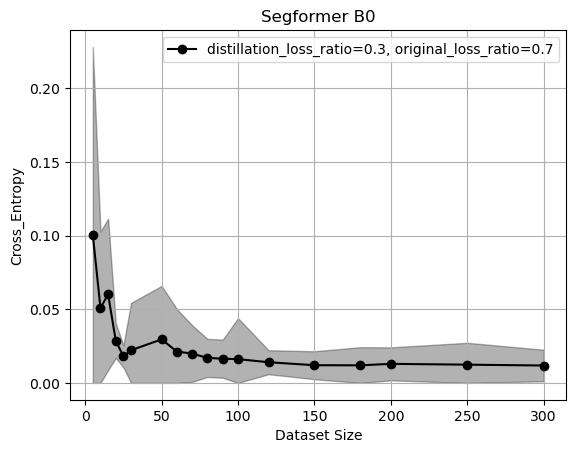

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()